In [1]:
# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import chardet
import csv
import os
import matplotlib.dates as mdates
from IPython.display import Image

### Inserez les chemins vers le fichiers CSV:

In [2]:
# on récupère les informations du dossier
dossier = './raw_data'
contenuDossier = os.listdir(dossier)
print(contenuDossier)
nombrePoints = 0
nomPoints = []
numeroPoints = []
# on parcours le dossier en recherchant les fichiers des points
for x in contenuDossier:
    if x.startswith('point'):
        nombrePoints += 1
        nomPoints.append(x)
        numeroPoints.append(x[5:7])
print(numeroPoints)

['.DS_Store', 'Point034', 'point13_29_07_15', 'point14_29_07_15', 'point15_29_07_15', 'schema_dispositif_AvAv_23_07_15.png']
['13', '14', '15']


In [3]:
def read_csv (chemin_fichier):
    #Detecter separateur
    with open(chemin_fichier, 'r') as file:
        sniffer = csv.Sniffer()
        sample_data = file.read(1024)
        detecter_separateur = (sniffer.sniff(sample_data).delimiter)

    if "Titre" in open(chemin_fichier).readline():
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur, skiprows=1)
    else:
        data_frame = pd.read_csv(chemin_fichier, sep=detecter_separateur)

    return data_frame 

In [4]:
# on crée un dictionnaire avec toutes les informations pour chaque point et on met les dictionnaires dans une liste
data = []
for x in nomPoints :
    dico = {}
    # le numéro
    dico['numero'] = x[5:7]
    # le nom
    dico['nom'] = x
    # la date
    dico['date'] = x[8:18]
    # le chemin vers le dossier
    dico['chemin'] = dossier + '/' + x
    with open(dico['chemin'] + '/geometrie.txt', 'r') as fichier:
        lignes = fichier.readlines()
        # le nom du capteur
        dico['capteur'] = lignes[1][:4]
        # la profondeur du capteur
        if lignes[3] == '\n' :
            dico['profondeur'] = 0
        else : 
            dico['profondeur'] = lignes[3]
        # les profondeurs auquelles on fait les mesures
        dico['profondeurMesures'] = []
        profMes = lignes[5].split(';')
        for num in profMes :
            dico['profondeurMesures'].append(int(num))
    # on va ensuite mettre les dataframes dans le dictionnaire
    contenuDossierPoint = os.listdir(dico['chemin'])
    for x in contenuDossierPoint:
        # la pression
        if x.startswith('p') and x.endswith('.csv'):
            dico['pression'] = read_csv(dico['chemin'] + '/' + x)
        # la température
        if x.startswith('t') and x.endswith('.csv'):
            dico['temperature'] = read_csv(dico['chemin'] + '/' + x)
    # dans les configurations du capteur on va chercher les données
    with open('configuration/pressure_sensors/P' + dico['capteur'][1:] +'.csv' ) as fichier :
        lignes = fichier.readlines()
        for l in lignes :
            if l.startswith('Intercept') :
                dico['intercept'] = float(l[10:-2])
            if l.startswith('dU/dH') :
                dico['dU/dH'] = float(l[6:-2])
            if l.startswith('dU/dT') :
                dico['dU/dT'] = float(l[6:-2]) 
    data.append(dico)


In [5]:
# en faisant data[0] on a accès à toutes les informations du point 1
data[1]

{'numero': '14',
 'nom': 'point14_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point14_29_07_15',
 'capteur': 'p507',
 'profondeur': 0,
 'profondeurMesures': [10, 20, 30, 40],
 'pression':        #  Date Heure GMT+02:00  \
 0      1  07/23/15 02:00:00 PM   
 1      2  07/23/15 02:15:00 PM   
 2      3  07/23/15 02:30:00 PM   
 3      4  07/23/15 02:45:00 PM   
 4      5  07/23/15 03:00:00 PM   
 ..   ...                   ...   
 558  559  07/29/15 09:30:00 AM   
 559  560  07/29/15 09:45:00 AM   
 560  561  07/29/15 10:00:00 AM   
 561  562  07/29/15 10:15:00 AM   
 562  563  07/29/15 10:30:00 AM   
 
      Tension V (LGR S/N: 10614065 SEN S/N: 10614065)  \
 0                                            0.01183   
 1                                            0.00080   
 2                                            0.00080   
 3                                            0.00092   
 4                                            0.00088   
 ..                                   

### On modifie les nom des colonnes du dataframe

In [6]:
# pour les températures
for x in data :
    # on supprime la première colonne si elle ne sert à rien
    for i in x['temperature'].columns :
        if not( i.startswith('Date') or i.startswith('Temp')) :
            del x['temperature'][i]
    for i in x['pression'].columns :
        if not( i.startswith('Date') or i.startswith('Tension') or i.startswith('Temp')) :
            del x['pression'][i]
    # on renomme les colonnes
    profondeur = x['profondeurMesures']
    colonnesT = ['dates']
    for num in profondeur :
        colonnesT.append('Temp_profondeur_'+ str(num))
    x['temperature'].columns = colonnesT
    colonnesP = ['dates', 'tension', 'temperature_stream']
    x['pression'].columns = colonnesP

In [7]:
# notamment la température et la pression
data[0]['temperature'].head(5)

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,07/23/15 12:30:00 PM,210.450,31.484,31.001,223.886
1,07/23/15 12:45:00 PM,206.695,17.986,18.390,537.327
2,07/23/15 01:00:00 PM,206.695,18.152,18.461,537.327
3,07/23/15 01:15:00 PM,208.536,17.867,18.176,537.327
4,07/23/15 01:30:00 PM,208.536,17.915,18.295,537.327


### Conversion de valeurs de tension a differance de charge

In [8]:
for point in data:
    k0 = float(point['intercept'])
    k1 = float(point['dU/dH'])
    k2 = float(point['dU/dT'])
    
    # Calcul de la colonne 'dH' en utilisant la formule H = 1/k1 * (U - k0 - k2 * T)
    U = point['pression']['tension'].astype(float)
    T = point['pression']['temperature_stream'].astype(float)
    point['pression']['dH'] = (1 / k1) * (U - k0 - k2 * T)

data[0]['pression']

,dates,tension,temperature_stream,dH
0,07/23/15 02:00:00 PM,0.58181,18.129,0.085770
1,07/23/15 02:15:00 PM,0.58059,18.081,0.085981
2,07/23/15 02:30:00 PM,0.57937,18.033,0.086192
3,07/23/15 02:45:00 PM,0.57937,18.224,0.085898
4,07/23/15 03:00:00 PM,0.57937,18.247,0.085863
...,...,...,...,...
558,07/29/15 09:30:00 AM,0.54884,14.194,0.095526
559,07/29/15 09:45:00 AM,0.54884,14.242,0.095452
560,07/29/15 10:00:00 AM,0.54884,14.194,0.095526
561,07/29/15 10:15:00 AM,0.54884,14.625,0.094863


### On enlève les valeurs NaN

In [9]:
for x in data :
    x['temperature'] = x['temperature'].dropna(axis = 0, how = 'any')
    x['pression'] = x['pression'].dropna(axis = 0, how='any')

In [10]:
# Conversion dans le bon format date
for point in data:
    point['pression']['dates'] = pd.to_datetime(point['pression']['dates'], format='%m/%d/%y %I:%M:%S %p')
    point['temperature']['dates'] = pd.to_datetime(point['temperature']['dates'], format='%m/%d/%y %I:%M:%S %p')

In [11]:
data[2]

{'numero': '15',
 'nom': 'point15_29_07_15',
 'date': '29_07_15',
 'chemin': './raw_data/point15_29_07_15',
 'capteur': 'p506',
 'profondeur': 0,
 'profondeurMesures': [7, 22, 37, 52],
 'pression':                  dates  tension  temperature_stream        dH
 0  2015-07-23 14:00:00  1.46215              26.549 -0.020266
 1  2015-07-23 14:15:00  1.52869              26.182 -0.007422
 2  2015-07-23 14:30:00  1.53724              27.014 -0.006440
 3  2015-07-23 14:45:00  1.38400              27.924 -0.036070
 4  2015-07-23 15:00:00  1.39255              28.369 -0.034794
 5  2015-07-23 15:15:00  1.35653              27.161 -0.040676
 6  2015-07-23 15:30:00  1.34982              26.695 -0.041589
 7  2015-07-23 15:45:00  1.34676              26.134 -0.041740
 8  2015-07-23 16:00:00  1.37241              23.256 -0.034706
 9  2015-07-23 16:15:00  1.45910              18.438 -0.014669
 10 2015-07-23 16:30:00  1.44567              18.200 -0.017024
 11 2015-07-23 16:45:00  1.37546              1

### On supprime les valeurs aberrants

In [12]:
from scipy import stats

for x in data :
    # Traiter chaque colonne sauf la colonne des dates
    columns_to_processP = [col for col in x['pression'].columns if col != 'dates']
    columns_to_processT = [col for col in x['temperature'].columns if col != 'dates']
    # Créer un DataFrame vide pour stocker les données traitées
    x['pression2'] = x['pression'][['dates']].copy()
    x['temperature2'] = x['temperature'][['dates']].copy()
    # Boucler à travers chaque colonne à traiter
    for column_name in columns_to_processP :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['pression'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 2
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['pression'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['pression2'][column_name] = df_cleaned[column_name]
    # pareil pour les températures
    for column_name in columns_to_processT :
        # Calculer le Z-score pour la colonne
        z_scores = np.abs(stats.zscore(x['temperature'][column_name]))
        # Définir un seuil pour le Z-score (par exemple, 3)
        threshold = 3
        # Sélectionner les lignes avec des Z-scores inférieurs au seuil
        df_cleaned = x['temperature'][z_scores < threshold] 
        # Copier les données traitées dans df_processed
        x['temperature2'][column_name] = df_cleaned[column_name]

In [13]:
for x in data :
    x['temperature2'] = x['temperature2'].dropna(axis = 0, how = 'any')
    x['pression2'] = x['pression2'].dropna(axis = 0, how='any')

In [14]:
# on met à jour la date de début de la mesure, la date de fin et la période
for x in data :
    x['dateDebut'] = x['pression2']['dates'].iloc[0]
    x['dateFin'] = x['pression2']['dates'][len(x['pression2']['dates'])-1]
    x['periode'] = x['dateFin'] - x['dateDebut']

### Création du fichier `info.txt`

In [15]:
# Ouvrez un fichier en mode écriture ('w')
for x in data :
    if os.path.exists(x['chemin'] + '/point' + x['numero'] + '_info.txt') :
        os.remove(x['chemin'] + '/point' + x['numero'] + '_info.txt')
    with open(x['chemin'] + '/point' + x['numero'] + '_info.txt', 'w') as fichier:
        # Parcourez le dictionnaire et écrivez les données dans le fichier
        fichier.write('Point_Name,Point' + x['numero'] + '\n')
        fichier.write('P_Sensor_Name,' + x['capteur'] + '\n')
        fichier.write('Implantation_Date,' + x['date'] + '\n')
        fichier.write('Meas_date,' + str(x['dateDebut']) + '\n')
        fichier.write('River_Deb,' '\n') 
        fichier.write('Delta_h,' + '\n')
        fichier.write('Periode,' + str(x['periode']) + '\n')

# Traitement du signal de temperature

### Représentation de la corrélation temperature pression (original) Point13

In [16]:
TsC = data[0]['pression2']['temperature_stream']
dH = data[0]['pression2']['dH']
Dates = data[0]['pression2']['dates']

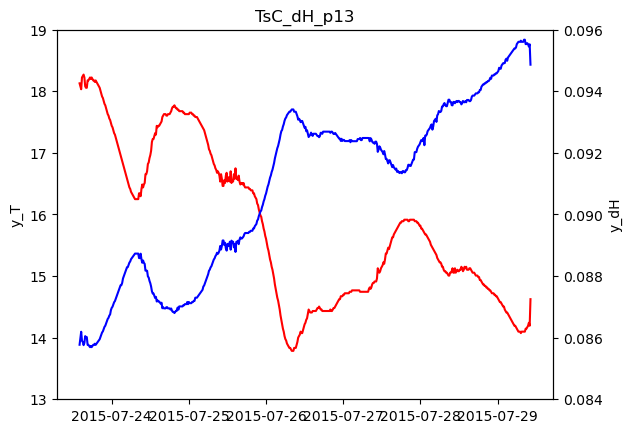

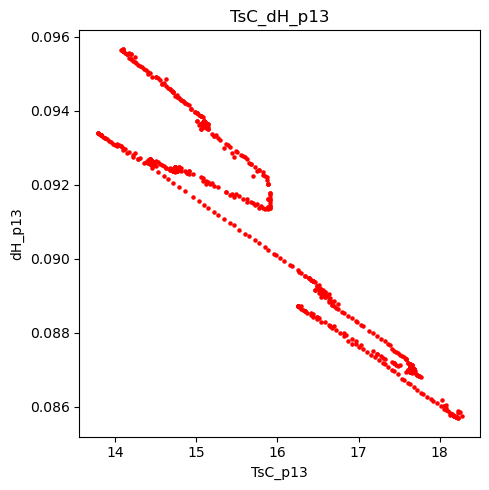

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_ylabel("y_T")
ax1.set_ylim(13, 19)
ax2.set_ylabel("y_dH")
ax2.set_ylim(0.084, 0.096)
ax1.plot(Dates, TsC, color="red", label="TsC_original_p13")
ax2.plot(Dates, dH, color="blue", label="dH_original_p13")
ax1.set_title("TsC_dH_p13")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, dH, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("dH_p13")
ax.set_title("TsC_dH_p13")

plt.tight_layout()
plt.show()

### Filtre passe-bas

In [18]:
# Butterworth filter method

from scipy import signal

data_to_filter = dH
order = 2
cutoff_freq = 2*(15/60/30)

b, a = signal.butter(order, cutoff_freq, 'lowpass')

filtered_data_low = signal.lfilter(b, a, data_to_filter)

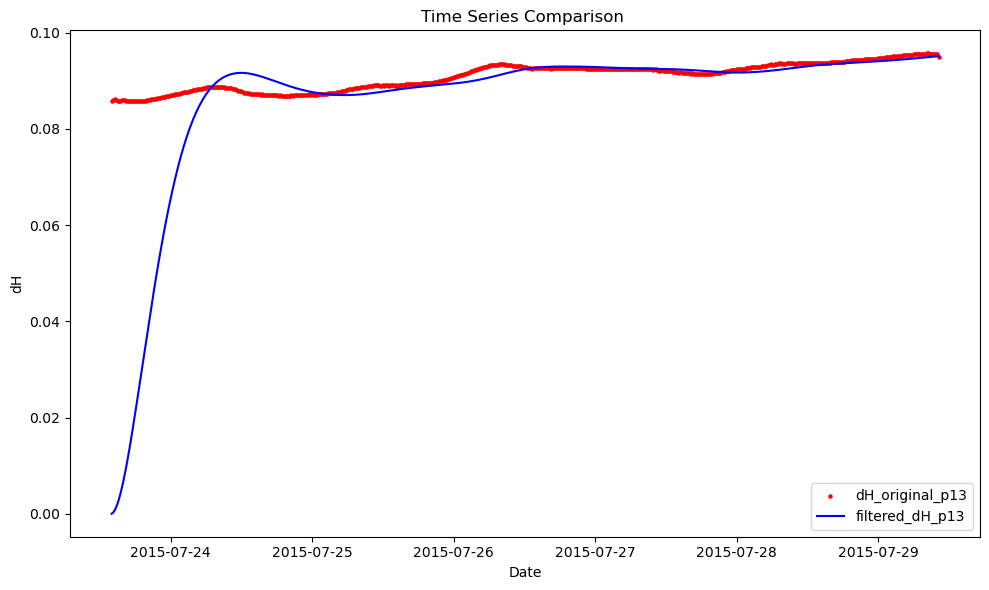

In [19]:
filtered_dH_low = pd.DataFrame({'filtered_dH': filtered_data_low, 'dates': Dates})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Dates, dH, color="red", label="dH_original_p13", s=5)
ax.plot(filtered_dH_low["dates"], filtered_dH_low["filtered_dH"], color="blue", label="filtered_dH_p13")
ax.set_xlabel("Date")
ax.set_ylabel("dH")
ax.set_title("Time Series Comparison ")
ax.legend()

plt.tight_layout()
plt.show()

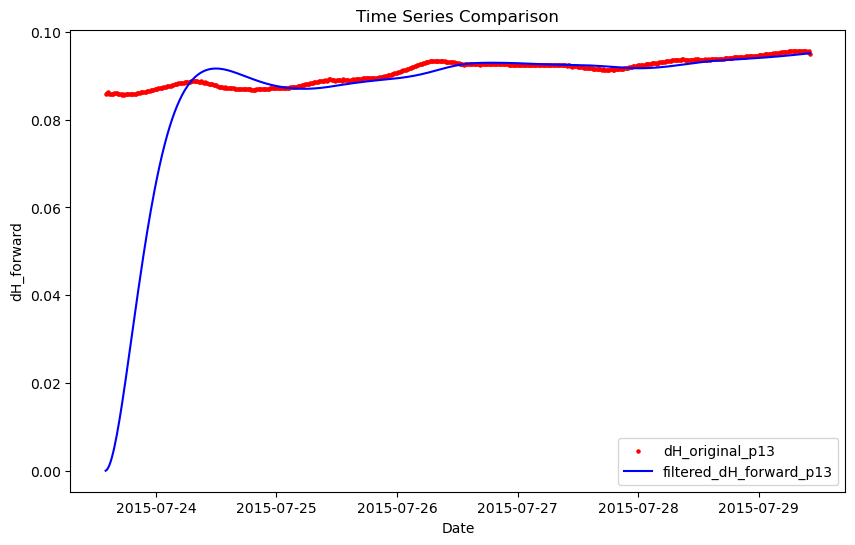

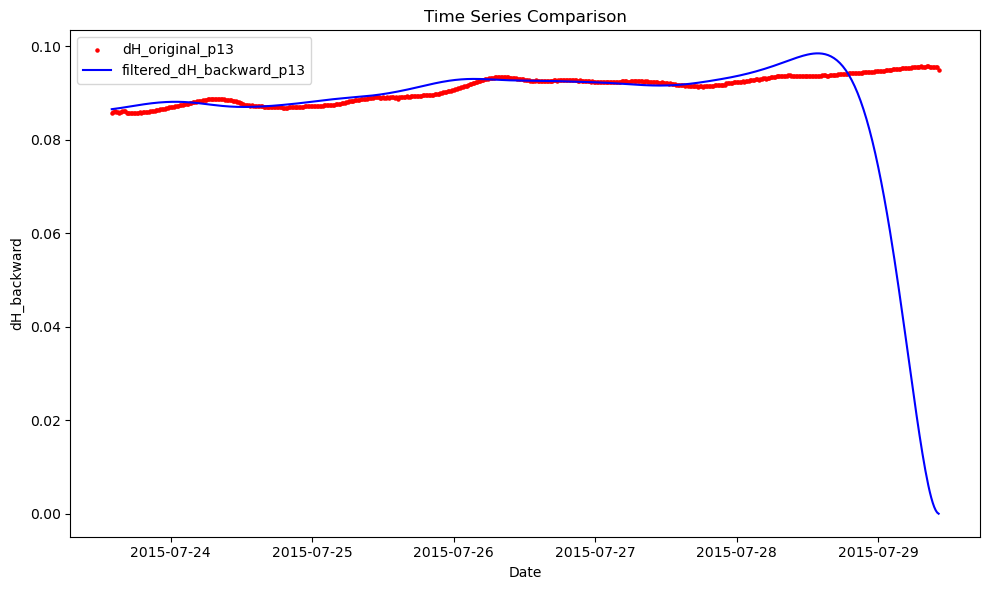

In [20]:
# Butterworth two-way-filter method

forward_filtered_signal_low = signal.lfilter(b, a, data_to_filter)

reversed_signal = data_to_filter[::-1]
backward_filtered_signal = signal.lfilter(b, a, reversed_signal)
backward_filtered_signal_low = backward_filtered_signal[::-1]

filtered_dH_low_forward = pd.DataFrame({'filtered_dH': forward_filtered_signal_low, 'dates': Dates})
filtered_dH_low_backward = pd.DataFrame({'filtered_dH': backward_filtered_signal_low, 'dates': Dates})


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Dates, dH, color="red", label="dH_original_p13", s=5)
ax.plot(filtered_dH_low_forward["dates"], filtered_dH_low_forward["filtered_dH"], color="blue", label="filtered_dH_forward_p13")
ax.set_xlabel("Date")
ax.set_ylabel("dH_forward")
ax.set_title("Time Series Comparison" )
ax.legend()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Dates, dH, color="red", label="dH_original_p13", s=5)
ax.plot(filtered_dH_low_backward["dates"], filtered_dH_low_backward["filtered_dH"], color="blue", label="filtered_dH_backward_p13")
ax.set_xlabel("Date")
ax.set_ylabel("dH_backward")
ax.set_title("Time Series Comparison")
ax.legend()

plt.tight_layout()
plt.show()

In [33]:
# Combination of two-way-filtered signal with a weight fonction

L = len(data_to_filter)
weight = np.zeros(L)
combined_filtered_signal_low = np.zeros(L)

a = 1.0 / L
for i in range(L):
    weight[i] = i * a

for i in range(L):
    combined_filtered_signal_low[i] = forward_filtered_signal_low[i] * weight[i] + backward_filtered_signal_low[i] * (1-weight[i])

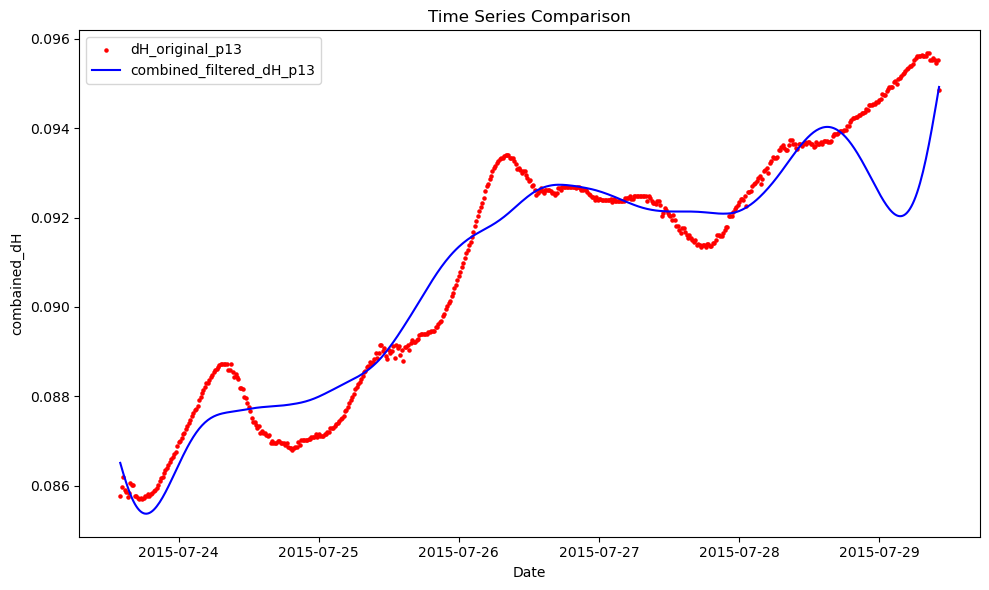

In [34]:
combined_filtered_dH_low_p13 = pd.DataFrame({'combined_filtered_dH': combined_filtered_signal_low, 'dates': Dates})

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Dates, dH, color="red", label="dH_original_p13", s=5)
ax.plot(combined_filtered_dH_low_p13["dates"], combined_filtered_dH_low_p13["combined_filtered_dH"], color="blue", label="combined_filtered_dH_p13")
ax.set_xlabel("Date")
ax.set_ylabel("combained_dH")
ax.set_title("Time Series Comparison")
ax.legend()

plt.tight_layout()
plt.show()

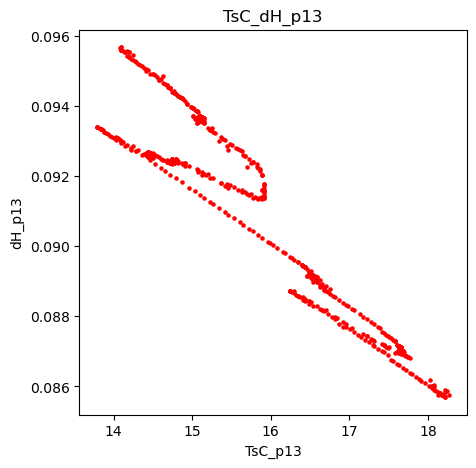

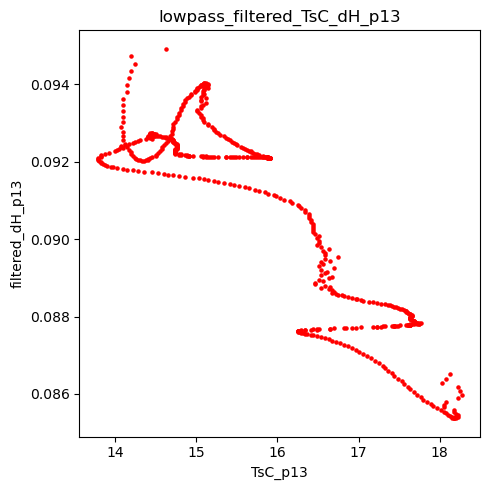

In [35]:
# Compare the correlation of the original and the lowpass filtered dH with TsC

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, dH, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("dH_p13")
ax.set_title("TsC_dH_p13")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, combined_filtered_signal_low, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("filtered_dH_p13")
ax.set_title("lowpass_filtered_TsC_dH_p13")

plt.tight_layout()
plt.show()

### Ondelette + filtre coupe-bande

In [36]:
# Ondelette analysis of TsC and dH

import pywt

wavelet = 'morl'  # Choose "Morlet" as basis function
scales = np.arange(1, 200)

# Continuous Wavelet Transform (CWT)
coeffs_TsC, freqs = pywt.cwt(TsC, scales, wavelet)
coeffs_dH, freqs = pywt.cwt(dH, scales, wavelet)

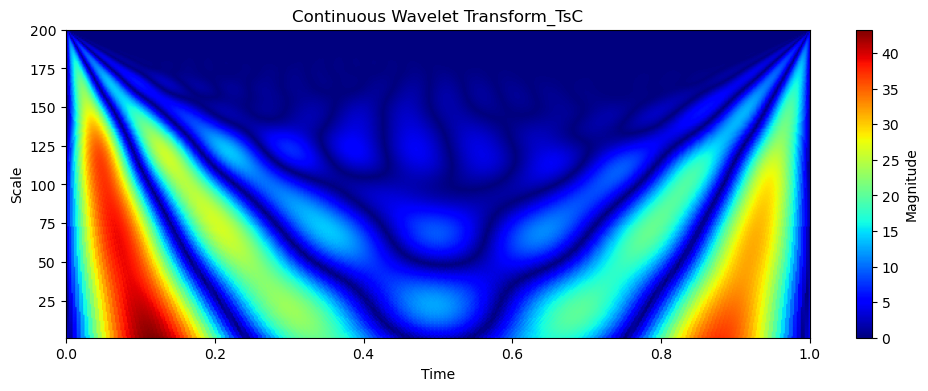

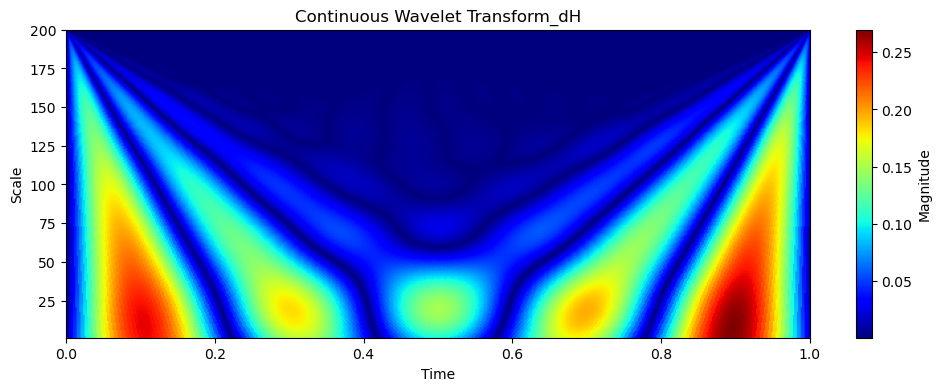

In [37]:
# Visualizing CWT coefficient plot

plt.figure(figsize=(12, 4))
plt.imshow(np.abs(coeffs_TsC), extent=[0, 1, 1, 200], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform_TsC')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.figure(figsize=(12, 4))
plt.imshow(np.abs(coeffs_dH), extent=[0, 1, 1, 200], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.title('Continuous Wavelet Transform_dH')
plt.xlabel('Time')
plt.ylabel('Scale')

plt.show()

In [38]:
# Using a bandstop filter to remove the frequency of the dominant influence of TsC on dH 

from scipy.signal import butter, lfilter

fs = 1/(15*60) # one data every 15min

def butter_bandstop_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='bandstop')
    y = lfilter(b, a, data)
    return y

lowcut = 1/26/3600
highcut = 1/22/3600

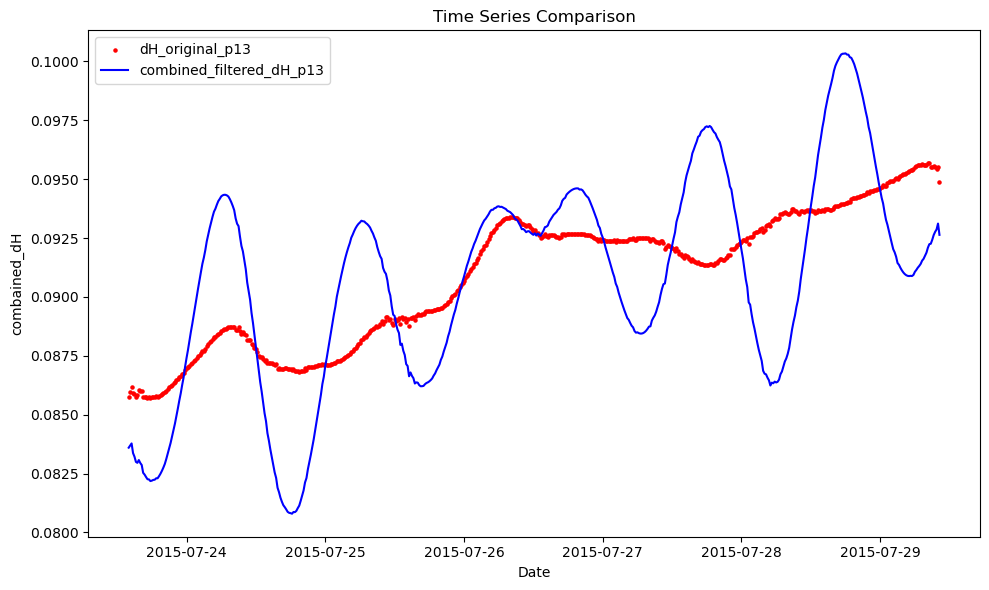

In [39]:
forward_filtered_signal_bandstop = butter_bandstop_filter(data_to_filter, lowcut, highcut, fs, order=4)
reversed_signal = data_to_filter[::-1]
backward_filtered_signal = butter_bandstop_filter(reversed_signal, lowcut, highcut, fs, order=4)
backward_filtered_signal_bandstop = backward_filtered_signal[::-1]


combined_filtered_signal_bandstop = np.zeros(L)

for i in range(L):
    combined_filtered_signal_bandstop[i] =  forward_filtered_signal_bandstop[i] * weight[i] + backward_filtered_signal_bandstop[i] * (1-weight[i])

combined_filtered_dH_bandstop_p13 = pd.DataFrame({'combined_filtered_dH': combined_filtered_signal_bandstop, 'dates': Dates})


fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(Dates, dH, color="red", label="dH_original_p13", s=5)
ax.plot(combined_filtered_dH_bandstop_p13["dates"], combined_filtered_dH_bandstop_p13["combined_filtered_dH"], color="blue", label="combined_filtered_dH_p13")
ax.set_xlabel("Date")
ax.set_ylabel("combained_dH")
ax.set_title("Time Series Comparison")
ax.legend()

plt.tight_layout()
plt.show()

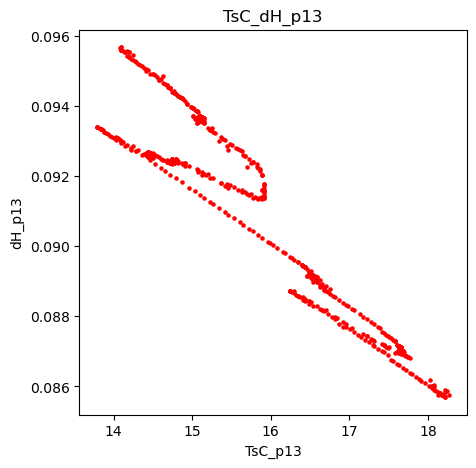

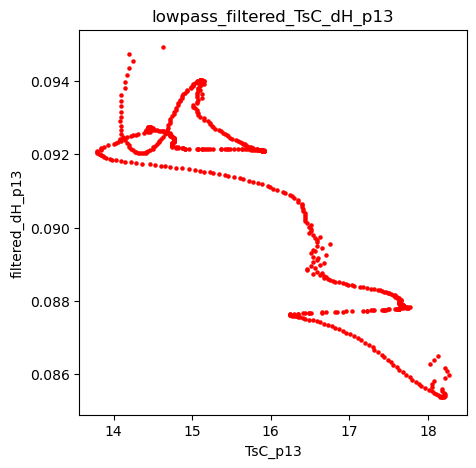

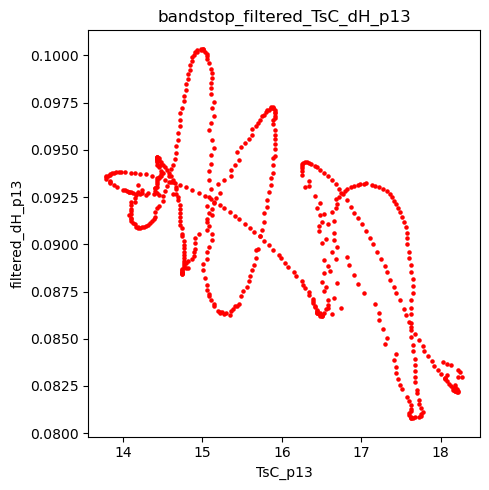

In [40]:
# Compare the correlation of the original, the lowpass filtered and the bandstop filtered dH with TsC

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, dH, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("dH_p13")
ax.set_title("TsC_dH_p13")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, combined_filtered_signal_low, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("filtered_dH_p13")
ax.set_title("lowpass_filtered_TsC_dH_p13")

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(TsC, combined_filtered_signal_bandstop, color="red", s=5)
ax.set_xlabel("TsC_p13")
ax.set_ylabel("filtered_dH_p13")
ax.set_title("bandstop_filtered_TsC_dH_p13")

plt.tight_layout()
plt.show()